# Sistemas de Recomendación - Netflix Prize Challenge

## Filtro Colaborativo a partir de descomposición UV

En este notebook vamos a implementar un sistema de recomendación usando un método tipo descomposición UV.

Vamos a usar la biblioteca Surprise. Te recomendamos tener abierta la [documentación](https://surprise.readthedocs.io/en/stable/getting_started.html) a medida que vas recorriendo esta sección.

### 1. Dataset y Train/test split

Carga de datos

In [1]:
#!pip install scikit-surprise
from platform import python_version

print(python_version())

3.7.9


In [2]:
#!pip install scikit-surprise


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd

import gc #garbage collector

from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split

In [4]:
import gc #garbage collector
from playsound import playsound
#!pip install playsound

import time

start_time = time.time()

path_data = "..\\data\\"
figures = "..\\figures\\"
netflix = "..\\data\\netflix-prize-data\\"

In [5]:
df1 = pd.read_csv(netflix + 'combined_data_1_with_movie_id.csv', dtype={'Rating': np.int8, 'movie_id': np.int16})
print(df1.shape)
df1.head()

(24053764, 3)


,User,Rating,Movie_id
0,1488844,3,1
1,822109,5,1
2,885013,4,1
3,30878,4,1
4,823519,3,1


In [6]:
df_title = pd.read_csv(netflix +'movie_titles.csv', encoding = "ISO-8859-1",index_col = 0, header = None, usecols = [0,2], names = ['Movie_Id', 'Name'])
df_title.head()

,Name
Movie_Id,
1,Dinosaur Planet
2,Isle of Man TT 2004 Review
3,Character
4,Paula Abdul's Get Up & Dance
5,The Rise and Fall of ECW


Primero, llevamos el dataset al formato que le gusta a la biblioteca. ¿En qué orden tienen que estar los atributos? Investigar qué hace la clase `Reader` y cuáles son sus parámetros.

In [12]:
#https://surprise.readthedocs.io/en/stable/reader.html

In [13]:
reader = Reader()

Luego, creamos el `Dataset` de Surprise usando `Dataset.load_from_df`

In [14]:
N_filas = 100000 # Limitamos el dataset a N_filas

data = Dataset.load_from_df(df1[['User', 'Movie_id', 'Rating']][:N_filas], reader)

¿Cómo les parece que es mejor hacer el split?¿Dejando películas en test, usuarios o combinaciones?

In [15]:
trainset, testset = train_test_split(data, test_size=.25)

### 2.2 Entrenamiento

Vamos a entrenar un algoritmo SVD. Explorar sus parámetros y su funcionamiento.

In [16]:
from surprise import SVD
algo = SVD()

Entrenamos sobre el `trainset`

In [17]:
algo.fit(trainset)

Y predecimos sobre el `testset`. Notar que para predecir sobre un conjunto de test se usa la función `test`.

In [18]:
predictions = algo.test(testset)

Explorar las característica de `predictions` y alguno de sus elementos

In [19]:
predictions[1]

Prediction(uid=653300, iid=17, r_ui=3.0, est=2.915810319634564, details={'was_impossible': False})

En cambio, si queremos predecir para un usuario y una película en particular, usamos la función `predict`

In [20]:
algo.predict(1328945,28)

Prediction(uid=1328945, iid=28, r_ui=None, est=3.5608116007547914, details={'was_impossible': False})

Exploremos un usuario, veamos cuáles películas le gustaron y cuáles les recomienda el sistema.

Películas que le gustaron

In [21]:
usuario = 1539350
rating = 5   # le pedimos peliculas a las que haya puesto 4 o 5 estrellas
df_user = df1[(df1['User'] == usuario) & (df1['Rating'] >= rating)]
df_user = df_user.reset_index(drop=True)
df_user['Name'] = df_title['Name'].loc[df_user.Movie_id].values
df_user

,User,Rating,Movie_id,Name
0,1539350,5,269,Parenthood
1,1539350,5,270,Sex and the City: Season 4
2,1539350,5,406,Hostage
3,1539350,5,1202,National Lampoon's Vacation
4,1539350,5,2862,The Silence of the Lambs
5,1539350,5,3151,Napoleon Dynamite
6,1539350,5,3605,The Wizard of Oz: Collector's Edition
7,1539350,5,3928,Nip/Tuck: Season 2
8,1539350,5,4159,Barbershop


Creamos donde vamos a guardar las recomendaciones

In [22]:
recomendaciones_usuario = df_title.iloc[:4499].copy()
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

(4499, 1)


,Name
Movie_Id,
1,Dinosaur Planet
2,Isle of Man TT 2004 Review
3,Character
4,Paula Abdul's Get Up & Dance
5,The Rise and Fall of ECW


Sacamos del dataframe todas las películas que ya sabemos que vio

In [23]:
usuario_vistas = df1[df1['User'] == usuario]
print(usuario_vistas.shape)
usuario_vistas.head()

(97, 3)


,User,Rating,Movie_id
219870,1539350,3,33
409717,1539350,4,111
445206,1539350,3,127
664099,1539350,4,175
894718,1539350,4,197


In [24]:
recomendaciones_usuario.drop(usuario_vistas.Movie_id, inplace = True)
recomendaciones_usuario = recomendaciones_usuario.reset_index()
recomendaciones_usuario.head()

,Movie_Id,Name
0,1,Dinosaur Planet
1,2,Isle of Man TT 2004 Review
2,3,Character
3,4,Paula Abdul's Get Up & Dance
4,5,The Rise and Fall of ECW


Y hacemos las recomendaciones

In [25]:
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['Movie_Id'].apply(lambda x: algo.predict(usuario, x).est)

In [26]:
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
print(recomendaciones_usuario.head(10))

    Movie_Id                                               Name  \
12        13  Lord of the Rings: The Return of the King: Ext...   
4          5                           The Rise and Fall of ECW   
24        25      Inspector Morse 31: Death Is Now My Neighbour   
17        18                                   Immortal Beloved   
29        30                             Something's Gotta Give   
27        28                                    Lilo and Stitch   
0          1                                    Dinosaur Planet   
2          3                                          Character   
1          2                         Isle of Man TT 2004 Review   
26        27  Sesame Street: Elmo's World: The Street We Liv...   

    Estimate_Score  
12        4.450399  
4         3.985803  
24        3.961293  
17        3.838552  
29        3.808015  
27        3.783016  
0         3.742558  
2         3.684696  
1         3.610438  
26        3.606692  


### 2. Evaluación

Para el conjunto de `testset`, evaluamos el error RMSE entre las predicciones y las verdaderas calificaciones que le habían dado a las películas. Para eso, buscar en la documentación cómo se hace.

In [27]:
from surprise import accuracy

accuracy.rmse(predictions)

RMSE: 1.0500


1.0499754391374938

### 3. Optimización de parámetros

**Ejercicio**: hacer un gráfico del desempeño del modelo en función del número de factores del `SVD`

In [28]:
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [1,2,4,8,16,32,64,128,256]

for factor in factores:
    print(f'\nNúmero de Factores: {factor}')
    algo = SVD(n_factors=factor)
    cv = cross_validate(algo, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))


Número de Factores: 1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0413  1.0434  1.0512  1.0453  0.0043  
Fit time          1.32    1.34    1.40    1.35    0.03    
Test time         0.32    0.30    0.29    0.30    0.01    

Número de Factores: 2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0461  1.0449  1.0442  1.0451  0.0008  
Fit time          1.41    1.38    1.39    1.39    0.01    
Test time         0.41    0.42    0.31    0.38    0.05    

Número de Factores: 4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0449  1.0524  1.0398  1.0457  0.0052  
Fit time          1.53    1.46    1.59    1.53    0.05    
Test time         0.32    0.31    0.30    0.31    0.01    

Número de Factores: 8
Evaluating RMSE of algorithm SVD on 3 split(s).

    

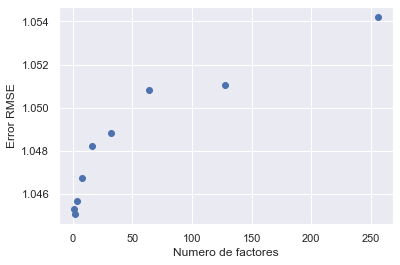

In [29]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

**Ejercicio**: recordar que, cuando entrenamos un `SVD`, estamos usando descenso por gradiente para minimizar una función de costo. Usar `GridSearchCV` para buscar valores óptimos para los siguientes parámetros (tres por parámetros, utilizar los valores default de referencia): `n_factors`, `n_epochs`, `lr_all` y `reg_all`. Estudiar qué representa cada uno de ellos mientras esperan. Tomarse un café.

In [30]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [5,50,100],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
gs.fit(data)


In [31]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

1.046209083430059
{'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}


## Extra: Agrandando el Dataset

Podemos sumar al dataset el resto de las calificaciones que no usamos.

Como corremos el riesgo de que se nos llene la memoria RAM, vamos a hacerlo de a poco y con cuidado. Arrancamos agregando las calificaciones que hay en `combined_data_2.txt`.

0. Reiniciar el Kernel
1. Abrir el archivo `combined_data_2.txt` con la función `load_data`.
2. Agregar una columna con el `Movie_id` al que corresponden las calificaciones. Si te animas, puedes crear una función que realice este paso.
3. Opcional: filtrar películas con pocas calificaciones
4. Abrir el archivo donde ya está procesado `combined_data_1.txt`. 
5. Agregar al final las nuevas calificaciones y guardarlo en un nuevo archivo.


Una vez que estén contentos con el procedimientos, repetir los pasos anteriores para los archivos faltantes.

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd

import gc #garbage collector

In [33]:
### 1

def load_data(name):
    df = pd.read_csv(name, header = None, names = ['User','Rating'], usecols = [0,1])
    return df


df2 = load_data(netflix + 'combined_data_2.txt')
print(df2.shape)

(26982302, 2)


In [34]:
### 2.
movies_ids_df2 = df2.User[df2.Rating.isna()].values
print(movies_ids_df2)
print(len(movies_ids_df2))

movies_ids_df2 = np.arange(4500,len(movies_ids_df2) + 4500)
print(movies_ids_df2)

['4500:' '4501:' '4502:' ... '9208:' '9209:' '9210:']
4711
[4500 4501 4502 ... 9208 9209 9210]


In [35]:
df2_nan = pd.DataFrame(pd.isnull(df2.Rating))
df2_nan = df2_nan[df2_nan['Rating'] == True]
idx_movies_ids = df2_nan.index.values
print(idx_movies_ids)

[       0      259      855 ... 26961403 26980373 26980497]


In [36]:
# Agregamos el indice de la ultima instancia del dataframe
idx_movies_ids = np.append(idx_movies_ids,df2.shape[0])
cantidad_criticas = np.diff(idx_movies_ids)
cantidad_criticas

array([  259,   596,   105, ..., 18970,   124,  1805], dtype=int64)

In [37]:
columna_movie_id = np.array([])
for i in range(cantidad_criticas.size):
    aux = np.full(cantidad_criticas[i], movies_ids_df2[i])
    columna_movie_id = np.concatenate((columna_movie_id, aux))

In [38]:
df2['Movie_id'] = columna_movie_id
del columna_movie_id

df2.dropna(inplace = True)
df2['User'] = df2['User'].astype(int)
df2['Movie_id'] = df2['Movie_id'].astype(np.int16)
df2['Rating'] = df2['Rating'].astype(np.int8)

gc.collect()

241

In [39]:
df2

,User,Rating,Movie_id
1,2532865,4,4500
2,573364,3,4500
3,1696725,3,4500
4,1253431,3,4500
5,1265574,2,4500
...,...,...,...
26982297,2420260,1,9210
26982298,761176,3,9210
26982299,459277,3,9210
26982300,2407365,4,9210


In [41]:
### 4.

df1 = pd.read_csv(netflix + 'combined_data_1_with_movie_id.csv', dtype={'Rating': np.int8, 'Movie_id': np.int16})
print(df1.shape)
df1.head()

(24053764, 3)


,User,Rating,Movie_id
0,1488844,3,1
1,822109,5,1
2,885013,4,1
3,30878,4,1
4,823519,3,1


In [42]:
### 5.

df = df1.copy()
del df1
df = df.append(df2)
print(df.shape)

(51031355, 3)


Chequeamos que estén todas las películas:

In [43]:
peliculas_presentes = df.Movie_id.unique()
peliculas_presentes

array([   1,    2,    3, ..., 9208, 9209, 9210], dtype=int16)

In [44]:
print((peliculas_presentes - np.arange(1,9210 + 1)).sum())

0


Y guardamos

In [46]:
if True:
    df.to_csv(netflix + 'combined_data_1y2_with_movie_id.csv', index= False)

In [47]:
playsound(figures+"war.mp3")
gc.collect()

end = time.time()
hours, rem = divmod(end-start_time, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

08:50:54.09
